## 0. Initialization

<b>Please execute this first cell now!</b> This will initialize some configurations and import all the necessary packages that we need.

In [3]:
import torch
import copy
import numpy as np
from crai.climatereconstructionai.model.net import CRAINet
from crai.climatereconstructionai.utils.netcdfloader import NetCDFLoader, InfiniteSampler
from tqdm import tqdm
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from utils import initialize_config, plot_sample, plot_results, create_video

# initialize_config() # don't bother with this!

ImportError: cannot import name 'initialize_config' from 'utils' (unknown location)

## 1. Data Preparation

Before we can start loading our data, we need to specify some configurations. Here are some of the important configurations for the data loading process:
<ul>
    <li><b>data_root:</b> The root directory of your data. This should contain the subdirectories <i>train/</i>, <i>val/</i> and <i>test/</i> for the training, validation and test data</li>
    <li><b>data_name:</b> The name of the data file in the data-root directory</li>
    <li><b>mask_dir:</b> The directory where the NetCDF4 file of the mask is stored</li>
    <li><b>mask_name:</b> The name of the mask file in the mask directory</li>
    <li><b>variable:</b> The variable name in the NetCDF4 file</li>
</ul>

In [2]:
# define data parameters
data_root = "data/"
data_name = "radolan.nc"
mask_dir = "data/"
mask_name = "mask.nc"
variable = "pr"

After defining the parameters, we can set up our data set. For this, climatereconstructionai implements a custom data set "NetCDFLoader" that is able to read in NetCDF4 files and applies preprocessing in the background. We use the data in the "train/" directory as our training data and the data in the "val/" directory as our validation data.

In [4]:
# create data set
# Dataloader comment: splits betwwen cpu and gpu, cpu prepares, gpu proccesses, NetCDFloader creates tensor
dataset_train = NetCDFLoader(data_root, [data_name], mask_dir, [mask_name], "train", [variable], [0, 0])
dataset_val = NetCDFLoader(data_root, [data_name], mask_dir, [mask_name], "val", [variable], [0, 0])

To see, how many samples our data set consists of, we can call the "__len__()" function. Also, we can access a data sample from the data set by calling the "__getitem__()" function and passing an index within the range of the data set length. Each sample consists of a tuple of three elements: the image, which is the ground truth masked with a missing value field, the mask itself and the ground truth with no missing values:

79521


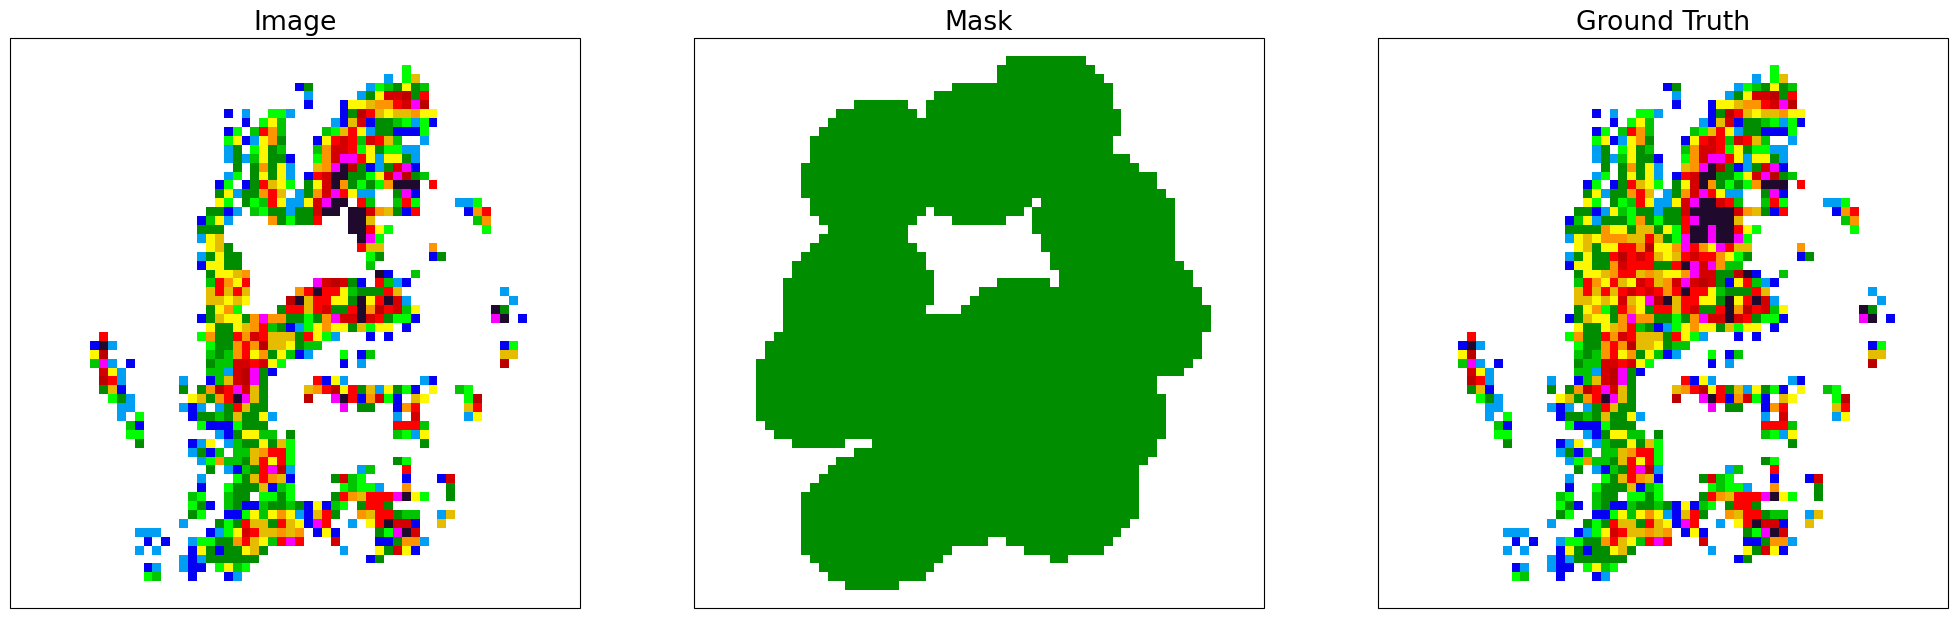

In [5]:
# print the length of the data set
print(dataset_train.__len__())

# sample and plot a single sample
image, mask, gt, _ = dataset_train.__getitem__(8350)
plot_sample(image, mask, gt)

In PyTorch, a data set is generally combined with a data loader. The data loader is used to efficiently sample data from our data set during training. Here, we can define how many samples should be loaded at once (batch-size) and by how many threads this data should be loaded in parallel to the training (number-of-threads). By wrapping the data loader around a python iterator, we can easily iterate the whole data set by calling the next() function on the data loader. This will return a set of random samples from our data set.

In [42]:
# data loader parameters
batch_size = 64 # higher number, better approximation of data, model updated after entire batch, small batch size = noisy
number_of_threads = 6 # specifies number of workers, multiprocessing, has an effect in preprocessing routine and speed

# create data loader
iterator_train = iter(DataLoader(dataset_train, batch_size=batch_size,
                                 sampler=InfiniteSampler(len(dataset_train)),
                                 num_workers=number_of_threads))
iterator_val = iter(DataLoader(dataset_val, batch_size=batch_size,
                               sampler=InfiniteSampler(len(dataset_val)),
                               num_workers=number_of_threads))

## 2. Model Definition

In this section, we define our model. Here are two useful parameters to play with, that change the model architecture:
<ul>
    <li><b>encoding_layers:</b> Defines the number of encoding layers for the model</li>
    <li><b>pooling_layers:</b> Defines the number of pooling layers for the model</li>
</ul>

In [43]:
# define model parameters
encoding_layers = 3 
pooling_layers = 1
# decreases image size by to so 2**layers < size

# model definition
model = CRAINet(img_size=dataset_train.img_sizes[0],
                enc_dec_layers=encoding_layers,
                pool_layers=pooling_layers,
                in_channels=1,
                out_channels=1,
                bounds=dataset_train.bounds)

print(model)

CRAINet(
  (encoder): ModuleList(
    (0): EncoderBlock(
      (partial_conv): PConvBlock(
        (input_conv): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), bias=False)
        (mask_conv): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), bias=False)
        (activation): ReLU()
      )
    )
    (1): EncoderBlock(
      (partial_conv): PConvBlock(
        (input_conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), bias=False)
        (mask_conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), bias=False)
        (activation): ReLU()
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): EncoderBlock(
      (partial_conv): PConvBlock(
        (input_conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (mask_conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (activation): ReLU()
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

## 3. Model Training

In this section, we define our loss function and train our model. We added a set of different configuration parameters training for your own needs. Here are some useful parameters:
<ul>
    <li><b>learning_rate:</b> The learning rate for the back-propagation</li>
    <li><b>save_model_interval:</b> The interval after which iterations the current state of the model should be saved</li>
    <li><b>max_iterations:</b> The number of iterations of the training cycle</li>
    <li><b>device:</b> "cpu", if the model should be trained on the CPU, or "cuda", if the model should be trained on a GPU</li>
</ul>

In [44]:
# define training parameters
learning_rate = 2e-3
save_model_interval = 1000
max_iterations = 20000
device = "cuda"

Next, we need to define a loss function, that determines on which criterion the model should be trained on. The L1 loss compares the ground truth with the model output by calculating the absolute difference between both: |L1 = gt - output|. The optimizer defines how the calculated loss should be applied to update the model which is also influenced by the learning rate.

In [45]:
# define loss function
loss = torch.nn.L1Loss()

# define optimizer
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

During training of the model, the program iterates the whole data set a fixed number of times which we defined in "max_iterations". 

In [46]:
train_losses = []
val_losses = []
models = {}

# push model to device
model = model.to(torch.device(device))

# monitoring the training progress
progress_bar = tqdm(range(0, max_iterations))
for i in progress_bar:
    n_iterations = i + 1

    # avtivate train mode
    model.train()

    # sample data
    image, mask, gt = [x.to(torch.device(device)) for x in next(iterator_train)[:3]]

    # forward step
    output = model(image, mask)

    # calculate the loss
    train_loss = loss(output, gt)

    # back-propagation step
    optimizer.zero_grad() # deletes all gradients before step
    train_loss.backward()
    optimizer.step()
    
    # calculate validation loss
    image_val, mask_val, gt_val = [x.to(torch.device(device)) for x in next(iterator_val)[:3]]
    model.eval()
    with torch.no_grad():
        output_val = model(image_val, mask_val)
    val_loss = loss(output_val, gt_val)

    # save loss values
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())
    
    # save model at current state
    if n_iterations % save_model_interval == 0:
        models[n_iterations] = copy.deepcopy(model)

100%|██████████| 20000/20000 [06:16<00:00, 53.10it/s]


After the training has completed, we can take a look at the loss function during the training progress. The loss values were stored in the log file in the previously defined interval. We can read this file and plot the results with the following function:

In [ ]:
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.title("Loss over iterations")


n_win = 100
plt.plot(np.convolve(train_losses, np.ones(n_win), "valid")/n_win, label="Train")
plt.plot(np.convolve(val_losses, np.ones(n_win), "valid")/n_win, label="Val")
plt.legend()

Since we don't have unlimited time, the model maybe could have needed a few more iterations until it reached an optimal state. However, we can also observe that the loss is at a quite low value already.

## 4. Model Evaluation

After we finished our training, we can use this model to apply some infilling of our test data, which the model hasn't seen so far. This data is stored in the data's <i>test/</i> subdirectory. Therefore, we define the iterations, where we saved a model, from which we want to infill the data.

In [37]:
# create validation data set
dataset_val = NetCDFLoader(data_root, [data_name], mask_dir, [mask_name], "infill", [variable], [0, 0])
inputs = torch.stack([dataset_val.__getitem__(i)[0] for i in range(dataset_val.__len__())]).to(torch.device("cpu"))
masks = torch.stack([dataset_val.__getitem__(i)[1] for i in range(dataset_val.__len__())]).to(torch.device("cpu"))
gts = torch.stack([dataset_val.__getitem__(i)[2] for i in range(dataset_val.__len__())]).to(torch.device("cpu"))

infill_iterations = [1000, 5000, 10000]
outputs = {}

# iterate through models and save predictions
for iteration in infill_iterations:
    model = models[iteration].to(torch.device("cpu"))
    model.eval()

    with torch.no_grad():
        outputs[iteration] = model(inputs, masks)

In [38]:
infilled = {}
for iteration in infill_iterations:
    infilled[iteration] = (1 - masks) * outputs[iteration] + masks * inputs

Now we can plot this data, comparing the output of early stage models with the models of later stages.

Iteration: 1000


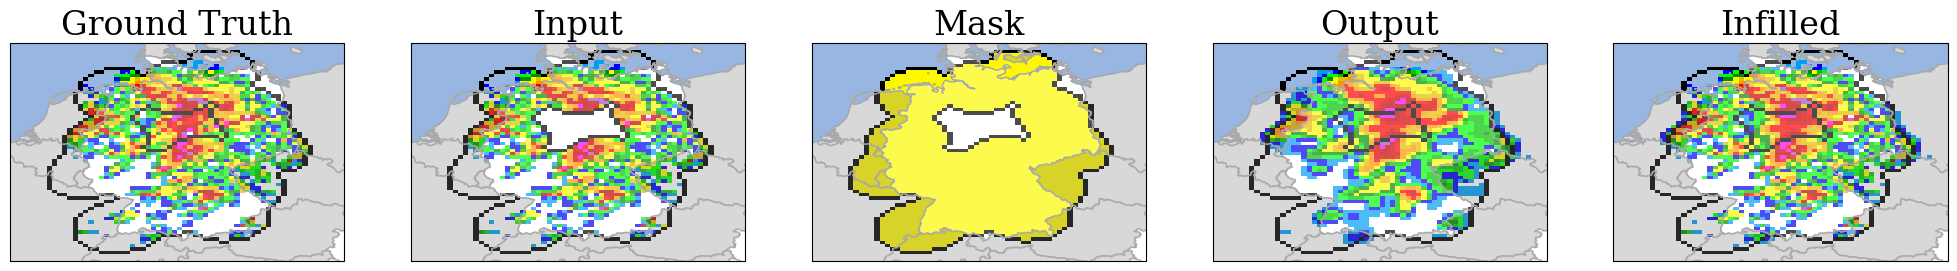

Iteration: 5000


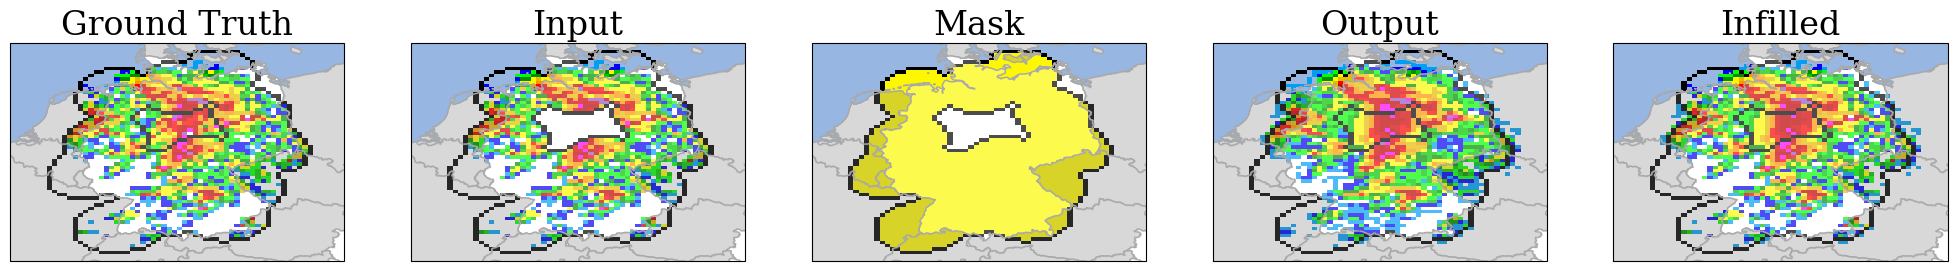

Iteration: 10000


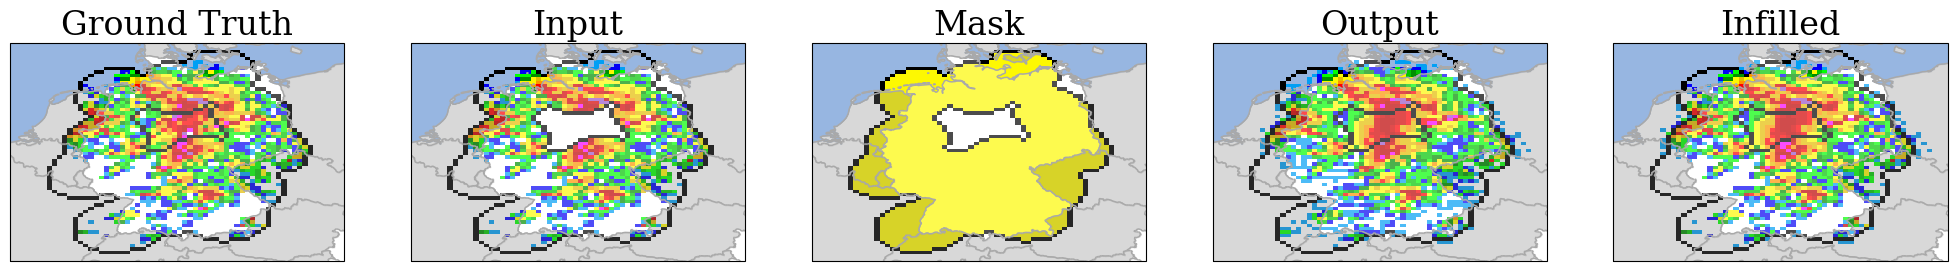

In [39]:
for iteration in infill_iterations:
    print("Iteration: {}".format(iteration))
    plot_results(gts, inputs, masks, outputs[iteration], infilled[iteration], dataset_val.xr_dss)

In [40]:
%%capture
create_video(infilled[infill_iterations[-1]], gts, masks, dataset_val.xr_dss)

<img src="crai_video.gif" width="1175" align="center">